# Train Faster R-CNN
The following image describes the topology of the Faster R-CNN with FPN

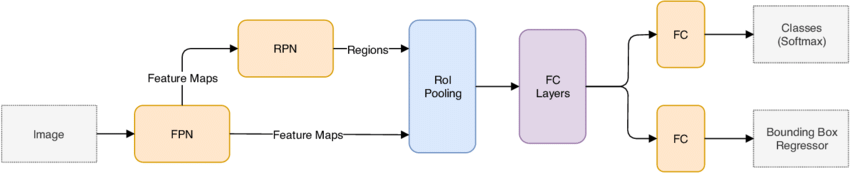

In [1]:
!pip install pandas matplotlib #scikit-learn

In [6]:
from typing import Tuple, List, Dict, Optional
from collections import OrderedDict
import os
import numpy as np
import pandas as pd
import json
import copy
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision
from torchvision.ops import box_convert

from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.optim import Adam

from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.models.detection.rpn import concat_box_prediction_layers

# Datapreparation

### Create target dataframe

In [7]:
data_dir = './dentex_dataset/origin/training_data/quadrant-enumeration-disease/xrays'
annotation_file = "./dentex_dataset/origin/training_data/quadrant-enumeration-disease/train_quadrant_enumeration_disease.json"

with open(annotation_file, "r") as json_file:
    json_content = json.load(json_file)
    annotations = pd.DataFrame(json_content["annotations"]).set_index("id")
    images = pd.DataFrame(json_content["images"]).set_index("id")

# group py image id, rename and drop some cols
annotations = annotations \
    .drop(columns=['iscrowd', 'segmentation', 'area']) \
    .rename(columns={'category_id_1': 'quadrant', 'category_id_2': 'tooth_number','category_id_3': 'disease'}) \
    .groupby('image_id').agg(lambda x: x.tolist())

# convert to integer
annotations['bbox'] = annotations['bbox'].apply(lambda x: [np.array(sublist).astype(int) for sublist in x])

# merge with image metadata
target_df = pd.merge(annotations, images, left_on='image_id', right_on='id', how='left')
target_df

,bbox,quadrant,tooth_number,disease,height,width,file_name
0,"[[542, 698, 220, 271], [1952, 693, 177, 270], ...","[3, 2, 3, 2, 2, 2, 1, 0, 2, 2, 2, 2, 3]","[7, 7, 6, 2, 3, 4, 5, 6, 5, 6, 1, 0, 0]","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2]",1316,2744,train_673.png
1,"[[792, 980, 168, 165], [2013, 1049, 140, 135],...","[3, 2, 2, 1]","[7, 7, 6, 5]","[0, 0, 1, 1]",1504,2872,train_283.png
2,"[[843, 838, 190, 325], [1006, 826, 177, 345], ...","[3, 3, 3, 3, 2, 2, 0, 0, 1, 1, 1, 2, 1, 1]","[6, 5, 4, 3, 3, 6, 7, 6, 1, 4, 5, 4, 7, 6]","[1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1]",1504,2872,train_95.png
3,"[[1082, 863, 109, 301], [1211, 891, 200, 298]]","[3, 3]","[3, 1]","[3, 2]",1504,2872,train_475.png
4,"[[1061, 504, 103, 298], [761, 464, 159, 240], ...","[0, 0, 1, 3, 3, 1]","[4, 7, 7, 4, 5, 4]","[1, 3, 1, 3, 3, 3]",1316,2867,train_62.png
...,...,...,...,...,...,...,...
673,"[[1795, 437, 208, 304], [1084, 781, 153, 268],...","[1, 3, 3, 3, 2]","[5, 4, 6, 7, 7]","[1, 1, 1, 0, 0]",1316,2910,train_338.png
674,"[[1916, 471, 127, 300], [1677, 795, 116, 279]]","[1, 2]","[6, 4]","[1, 1]",1316,2851,train_657.png
675,"[[1042, 418, 96, 293], [933, 423, 129, 284], [...","[0, 0, 1]","[4, 5, 6]","[3, 1, 1]",1316,2850,train_344.png
676,"[[2185, 855, 186, 310], [658, 454, 157, 356], ...","[2, 0, 3, 1, 2, 0, 1]","[7, 7, 6, 6, 4, 4, 3]","[0, 1, 1, 1, 1, 2, 2]",1504,2872,train_599.png


In [8]:
disease_dict = {
    0: "Impacted",
    1: "Caries",
    2: "Periapical Lesion",
    3: "Deep Caries"
}

In [9]:
def convert_bbox(bbox):
    return box_convert(torch.Tensor(bbox), 'xywh', 'xyxy')

def reverse_convert_bbox(bbox):
    return box_convert(torch.Tensor(bbox), 'xyxy', 'xywh')

In [10]:
def resize_bbox_xywh(bbox, old_size, new_size):
    x_scale = new_size[0] / old_size[0]
    y_scale = new_size[1] / old_size[1]
    
    return [bbox[0] * x_scale, bbox[1] * y_scale, bbox[2] * x_scale, bbox[3] * y_scale]

In [11]:
# test algorithm output [ X_min, Y_min, X_max, Y_max ]
height = 1316
width = 2744
[convert_bbox(resize_bbox_xywh(bbox, (width, height), (512,512) )) for bbox in target_df['bbox'][0]]

[tensor([101.1312, 271.5623, 142.1808, 376.9970]),
 tensor([364.2216, 269.6170, 397.2478, 374.6626]),
 tensor([125.9475, 275.4529, 171.2886, 392.1702]),
 tensor([272.9796, 282.0669, 291.2653, 447.4164]),
 tensor([286.6006, 292.9605, 305.8192, 441.1915]),
 tensor([298.5423, 296.4620, 321.3061, 427.5745]),
 tensor([317.3878, 144.3404, 344.4431, 257.1672]),
 tensor([145.3528, 146.2857, 169.9825, 269.6170]),
 tensor([311.0437, 281.2888, 355.2653, 419.7933]),
 tensor([336.9796, 270.7842, 381.2012, 390.6140]),
 tensor([262.1574, 281.6778, 276.1516, 419.0152]),
 tensor([250.7755, 280.1216, 265.1429, 429.9088]),
 tensor([240.3265, 281.2888, 251.8951, 431.8541])]

### Dataset

In [12]:
class RCNNDentexDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, target_df, image_size):
        self.root_dir = root_dir
        self.target_df = target_df
        self.image_size = image_size
        # Define transform
        self.transform = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor()
        ])

        self.image_dict = {}
        # Iterate target df
        for idx, row in self.target_df.iterrows():
            file_path = os.path.join(self.root_dir, row['file_name'])
            # Check if target images exists
            if os.path.exists(file_path):
                self.image_dict[idx] = { 'image_path': file_path, 'bboxes': {}, 'labels': {} }
                # Encode Labels
                self.image_dict[idx]['labels'] = [
                    torch.tensor(disease, dtype=torch.int64)
                    for disease in row['disease']
                ] 
                # Convert and resize bounding boxes
                height = row['height']
                width = row['width']
                self.image_dict[idx]['bboxes'] = [
                    convert_bbox(
                        resize_bbox_xywh(bbox, (width, height), self.image_size
                    )) 
                    for bbox in row['bbox']
                ]

    def __len__(self):
        return len(self.image_dict)

    def __getitem__(self, idx):
        # Load & transform image
        img_path = self.image_dict[idx]['image_path']
        img = Image.open(img_path).convert("L")
        img = self.transform(img)

        # Get the targets
        target = {}
        target["boxes"] = self.image_dict[idx]['bboxes']
        target["labels"] = [label for label in self.image_dict[idx]['labels']]

        return img, target

In [13]:
# Create the dataset
dataset = RCNNDentexDataset(root_dir=data_dir, target_df=target_df, image_size=(256,256))

#Check the dataset
(image, target) = dataset[1]
target

{'boxes': [tensor([ 70.5961, 166.8085,  85.5710, 194.8936]),
  tensor([179.4317, 178.5532, 191.9109, 201.5319]),
  tensor([162.5850, 169.3617, 182.9972, 212.7660]),
  tensor([154.3844, 115.5745, 166.8635, 158.4681])],
 'labels': [tensor(0), tensor(0), tensor(1), tensor(1)]}

In [14]:
BATCH_SIZE = 6 # Set as high as possible
NUM_WORKERS = 1

# Define the size of the validation set
test_size = int(0.1 * len(dataset))  
val_size = int(0.2 * len(dataset))  
train_size = len(dataset) - val_size - test_size

# Split the dataset into training and validation sets
train_dataset = torch.utils.data.Subset(dataset, range(train_size))
val_dataset = torch.utils.data.Subset(dataset, range(val_size))
test_dataset = torch.utils.data.Subset(dataset, range(test_size))

# Pad batch to have the same shape
def collate_fn(batch):
    max_num_boxes = max(len(item[1]) for item in batch)
    
    images = []
    targets = []
    
    for image, target in batch:
        images.append(image)
        
        # Pad target if it has fewer boxes
        if len(target) < max_num_boxes:
            target = np.pad(target, ((0, max_num_boxes - len(target)), (0, 0)), mode='constant')
        
        targets.append(target)
    
    # Convert each dictionary in targets to tensor
    targets = [{k: v for k, v in t.items()} for t in targets]
    
    return images, targets

# Define your data loaders
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)

In [15]:
# Display first item
data_iter = iter(val_loader)
(image, targets) = next(data_iter)
targets

[{'boxes': [tensor([ 50.5656, 135.7812,  71.0904, 188.4985]),
   tensor([182.1108, 134.8085, 198.6239, 187.3313]),
   tensor([ 62.9738, 137.7264,  85.6443, 196.0851]),
   tensor([136.4898, 141.0334, 145.6326, 223.7082]),
   tensor([143.3003, 146.4802, 152.9096, 220.5957]),
   tensor([149.2711, 148.2310, 160.6531, 213.7872]),
   tensor([158.6939,  72.1702, 172.2216, 128.5836]),
   tensor([ 72.6764,  73.1429,  84.9913, 134.8085]),
   tensor([155.5219, 140.6444, 177.6327, 209.8967]),
   tensor([168.4898, 135.3921, 190.6006, 195.3070]),
   tensor([131.0787, 140.8389, 138.0758, 209.5076]),
   tensor([125.3878, 140.0608, 132.5714, 214.9544]),
   tensor([120.1633, 140.6444, 125.9475, 215.9271])],
  'labels': [tensor(0),
   tensor(0),
   tensor(1),
   tensor(1),
   tensor(1),
   tensor(1),
   tensor(1),
   tensor(1),
   tensor(1),
   tensor(1),
   tensor(2),
   tensor(2),
   tensor(2)]},
 {'boxes': [tensor([ 70.5961, 166.8085,  85.5710, 194.8936]),
   tensor([179.4317, 178.5532, 191.9109, 201.

In [16]:
lr = 1e-5

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT") # for pretrained use weights="DEFAULT"

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model
    
num_classes = len(disease_dict) + 1 # Background is also a class
model = get_model_instance_segmentation(num_classes)

In [13]:
# RCNN does not output losses, so it needs to be comupted, see https://stackoverflow.com/questions/71288513/how-can-i-determine-validation-loss-for-faster-rcnn-pytorch
def eval_forward(model, images, targets):
    # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
    """
    Args:
        images (list[Tensor]): images to be processed
        targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)
    Returns:
        result (list[BoxList] or dict[Tensor]): the output from the model.
            It returns list[BoxList] contains additional fields
            like `scores`, `labels` and `mask` (for Mask R-CNN models).
    """
    model.eval()

    original_image_sizes: List[Tuple[int, int]] = []
    for img in images:
        val = img.shape[-2:]
        assert len(val) == 2
        original_image_sizes.append((val[0], val[1]))

    images, targets = model.transform(images, targets)

    # Check for degenerate boxes
    if targets is not None:
        for target_idx, target in enumerate(targets):
            boxes = target["boxes"]
            degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
            if degenerate_boxes.any():
                # print the first degenerate box
                bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                degen_bb: List[float] = boxes[bb_idx].tolist()
                raise ValueError(
                    "All bounding boxes should have positive height and width."
                    f" Found invalid box {degen_bb} for target at index {target_idx}."
                )

    features = model.backbone(images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([("0", features)])
    model.rpn.training=True
    #model.roi_heads.training=True


    #####proposals, proposal_losses = model.rpn(images, features, targets)
    features_rpn = list(features.values())
    objectness, pred_bbox_deltas = model.rpn.head(features_rpn)
    anchors = model.rpn.anchor_generator(images, features_rpn)

    num_images = len(anchors)
    num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
    num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
    objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
    # apply pred_bbox_deltas to anchors to obtain the decoded proposals
    # note that we detach the deltas because Faster R-CNN do not backprop through
    # the proposals
    proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
    proposals = proposals.view(num_images, -1, 4)
    proposals, scores = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)

    proposal_losses = {}
    assert targets is not None
    labels, matched_gt_boxes = model.rpn.assign_targets_to_anchors(anchors, targets)
    regression_targets = model.rpn.box_coder.encode(matched_gt_boxes, anchors)
    loss_objectness, loss_rpn_box_reg = model.rpn.compute_loss(
        objectness, pred_bbox_deltas, labels, regression_targets
    )
    proposal_losses = {
        "loss_objectness": loss_objectness,
        "loss_rpn_box_reg": loss_rpn_box_reg,
    }

    #detections, detector_losses = model.roi_heads(features, proposals, images.image_sizes, targets)
    image_shapes = images.image_sizes
    proposals, matched_idxs, labels, regression_targets = model.roi_heads.select_training_samples(proposals, targets)
    box_features = model.roi_heads.box_roi_pool(features, proposals, image_shapes)
    box_features = model.roi_heads.box_head(box_features)
    class_logits, box_regression = model.roi_heads.box_predictor(box_features)

    result: List[Dict[str, torch.Tensor]] = []
    detector_losses = {}
    loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
    detector_losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}
    boxes, scores, labels = model.roi_heads.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
    num_images = len(boxes)
    for i in range(num_images):
        result.append(
            {
                "boxes": boxes[i],
                "labels": labels[i],
                "scores": scores[i],
            }
        )
    detections = result
    detections = model.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]
    model.rpn.training=False
    model.roi_heads.training=False
    losses = {}
    losses.update(detector_losses)
    losses.update(proposal_losses)
    return losses, detections

In [14]:
def train_model(model, train_dataloader, validation_dataloader, optimizer, lr=1e-5, num_epochs=30, patience=2):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    increasing_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, targets in train_dataloader:
            images = [image.to(device) for image in images]
            targets = [{k: torch.stack(v).to(device) if isinstance(v, list) else v.to(device) for k, v in t.items()} for t in targets]
            # format loss dict: {'loss_classifier': tensor(0.2335, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2740, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0672, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0671, device='cuda:0', grad_fn=<DivBackward0>)}
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            train_loss += losses.item()
        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for images, targets in validation_dataloader:
                images = [image.to(device) for image in images]
                targets = [{k: torch.stack(v).to(device) if isinstance(v, list) else v.to(device) for k, v in t.items()} for t in targets]
                loss_dict, _ = eval_forward(model, images, targets)
                val_loss += sum(loss.sum().item() if loss.dim() else loss.item() for loss in loss_dict.values()) if loss_dict else 0
            avg_val_loss = val_loss / len(validation_dataloader)
            val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

        # Early stopping and save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            increasing_epochs = 0
            torch.save(model.state_dict(), 'faster_rcnn_resnet50_fpn_v2_best_lr{}.pt'.format(lr))
        else:
            increasing_epochs += 1
            if increasing_epochs >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return model, train_losses, val_losses

In [15]:
def save_plot(train_losses, val_losses, lr):
    plt.figure(figsize=(12, 6))
    plt.title("Faster R-CNN ResNet-50 FPN V2@LR{}".format(lr))

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()
    plt.tight_layout()

    plt.savefig('train_val_loss_lr{}.png'.format(lr), dpi=600)

## Hyperparameter Search: Learning Rate

Training with learning rate: 5e-07
Epoch 1/50, Training Loss: 2.943267844617367, Validation Loss: 2.5600351234493046
Epoch 2/50, Training Loss: 2.157936705648899, Validation Loss: 1.867677640169859
Epoch 3/50, Training Loss: 1.6014987900853157, Validation Loss: 1.4266691449219766
Epoch 4/50, Training Loss: 1.2552697353065014, Validation Loss: 1.1566572404750015
Epoch 5/50, Training Loss: 1.0537959210574628, Validation Loss: 1.0015745326552703
Epoch 6/50, Training Loss: 0.9325105883181095, Validation Loss: 0.9096131107729414
Epoch 7/50, Training Loss: 0.8652369327843189, Validation Loss: 0.8541889261940251
Epoch 8/50, Training Loss: 0.8211417548358441, Validation Loss: 0.8123761064818372
Epoch 9/50, Training Loss: 0.7921981912106275, Validation Loss: 0.7879785381095565
Epoch 10/50, Training Loss: 0.7683130498975516, Validation Loss: 0.7701731895946938
Epoch 11/50, Training Loss: 0.7505191478878259, Validation Loss: 0.7500550593856884
Epoch 12/50, Training Loss: 0.7368251852691173, Valid

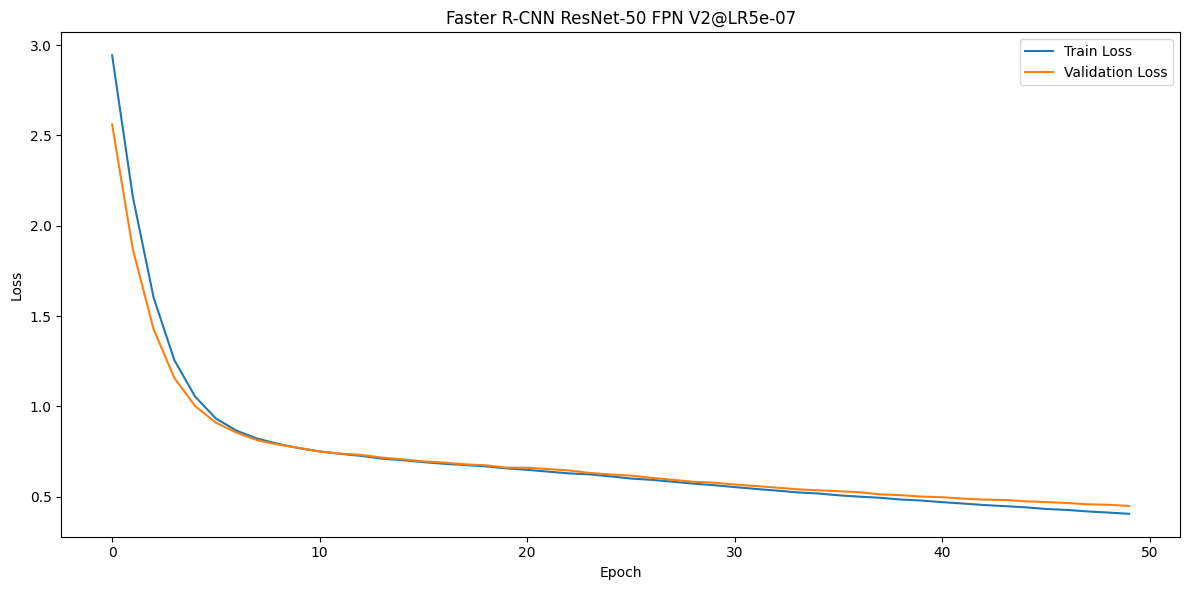

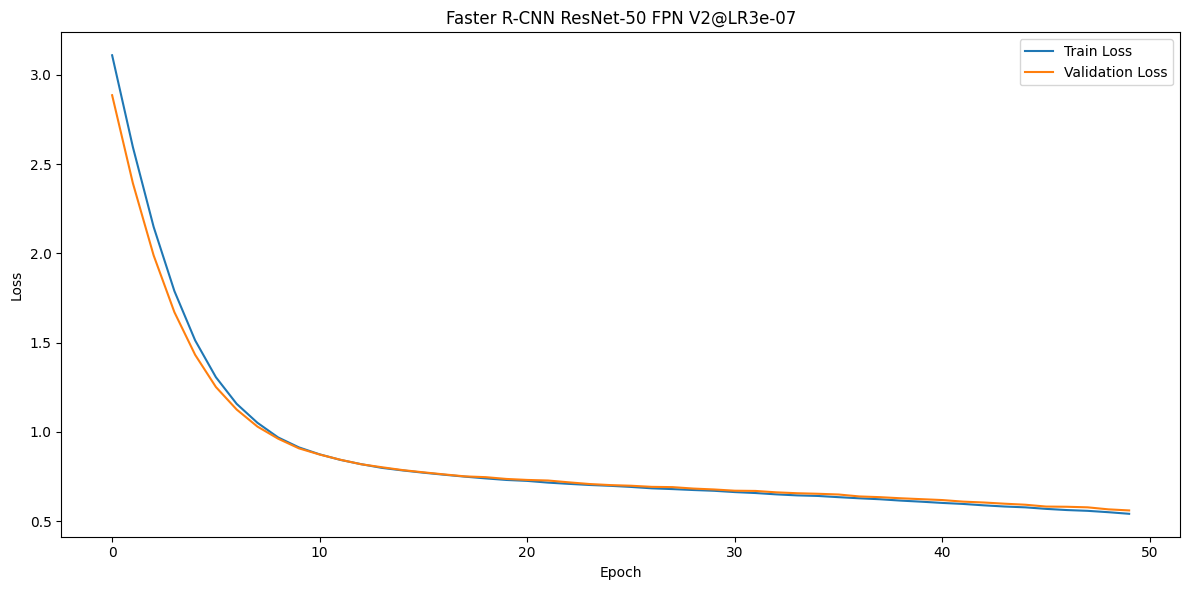

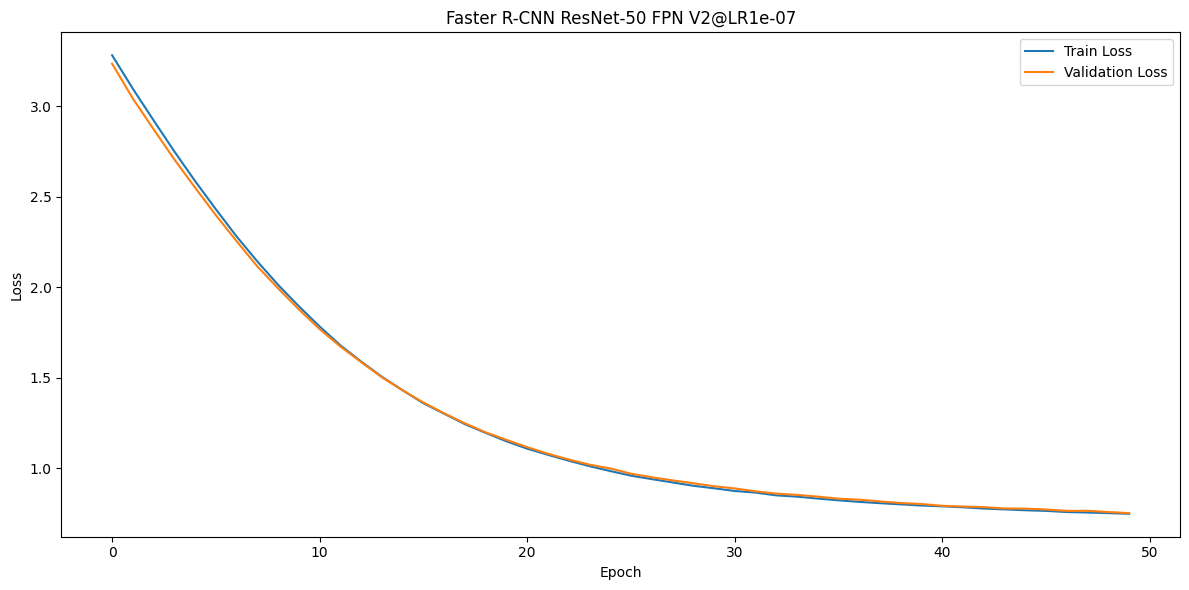

In [16]:
def grid_search(model, train_dataloader, validation_dataloader, learning_rates=[5e-7, 3e-7, 1e-7], num_epochs=50, patience=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for lr in learning_rates:
        print(f"Training with learning rate: {lr}")
        model_copy = copy.deepcopy(model)  # Create a copy of the model for each learning rate
        optimizer = torch.optim.Adam(model_copy.parameters(), lr=lr)
        trained_model, train_losses, val_losses = train_model(model_copy, train_dataloader, validation_dataloader, optimizer, lr, num_epochs, patience)
        print(f"Best validation loss for learning rate {lr}: {min(val_losses)}")
        save_plot(train_losses, val_losses, lr)

# Perform GridSearch
grid_search(model, train_loader, val_loader)

## Training

In [17]:
'''
model, train_losses, val_losses = train_model(
    model=model,
    train_dataloader=train_loader,
    validation_dataloader=val_loader,
    optimizer=optimizer,
    num_epochs=2
)
'''

'\nmodel, train_losses, val_losses = train_model(\n    model=model,\n    train_dataloader=train_loader,\n    validation_dataloader=val_loader,\n    optimizer=optimizer,\n    num_epochs=2\n)\n'

## Output

In [100]:
# Load the image
model_path = './faster_rcnn_resnet50_fpn_v2_best_lr5e-07.pt'
model = get_model_instance_segmentation(num_classes)
model.load_state_dict(torch.load(model_path))
model.to('cuda')

image_path = './dentex_dataset/segmentation/enumeration32/xrays/train_2.png'
true_labels = target_df.loc[target_df['file_name'] == 'train_2.png']['disease'].values[0]
true_bboxes = [convert_bbox(bbox) for bbox in target_df.loc[target_df['file_name'] == 'train_2.png']['bbox'].values[0]]
true_scores = np.full(len(true_labels), 100)
image = Image.open(image_path).convert("L")
width, height = image.size

# Convert the image to PyTorch tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
image_tensor = transform(image)

# Add an extra dimension because the model expects batches
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.to('cuda')

# Get the model's output
model.eval()
output = model(image_tensor)[0]

# Get the bounding boxes, labels and scores from the model's output
boxes = output['boxes'].detach().cpu().numpy()
labels = output['labels'].detach().cpu().numpy()
scores = output['scores'].detach().cpu().numpy()

# Calculate Original bounding boxes
original_boxes = [
    resize_bbox_xywh(
        bbox,
        (256,256),
        (width, height))
    for bbox in boxes]

transform = transforms.Compose([
    transforms.ToTensor()
])

original_image = transform(image)
original_image = original_image.unsqueeze(0)
original_image = original_image.to('cuda')

In [108]:
# Filter confidence > 85%
scores = scores[scores >= 0.88]
n = len(scores)
labels = labels[:n]
original_boxes = original_boxes[:n]

In [109]:
true_labels

[0, 1, 1, 0]

In [110]:
labels

array([1, 1, 1, 1, 1])

In [111]:
disease_dict

{0: 'Impacted', 1: 'Caries', 2: 'Periapical Lesion', 3: 'Deep Caries'}

In [112]:
def show_image(image_tensor, boxes, labels, scores):
    color_map={ 0: 'c', 1: 'y', 2: 'g', 3: 'b'}
    
    # Convert the image tensor back to numpy array
    image_array = image_tensor.cpu().squeeze(0).permute(1, 2, 0).numpy()

    # Create a matplotlib figure with a large size
    fig, ax = plt.subplots(1, figsize=(15, 15))
    
    # Display the image
    ax.imshow(np.clip(image_array, 0, 1), cmap='gray')

    # Draw each bounding box
    for box, label, score in zip(boxes, labels, scores):
        # Get the color for this label
        color = color_map.get(label, 'r')  # Default to 'r' if label not in color_map

        # Create a Rectangle patch
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor=color, facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add label and score text
        plt.text(box[0], box[1], f'{disease_dict[label]}: {score:.2f}', color=color)

    # Show the figure
    plt.show()

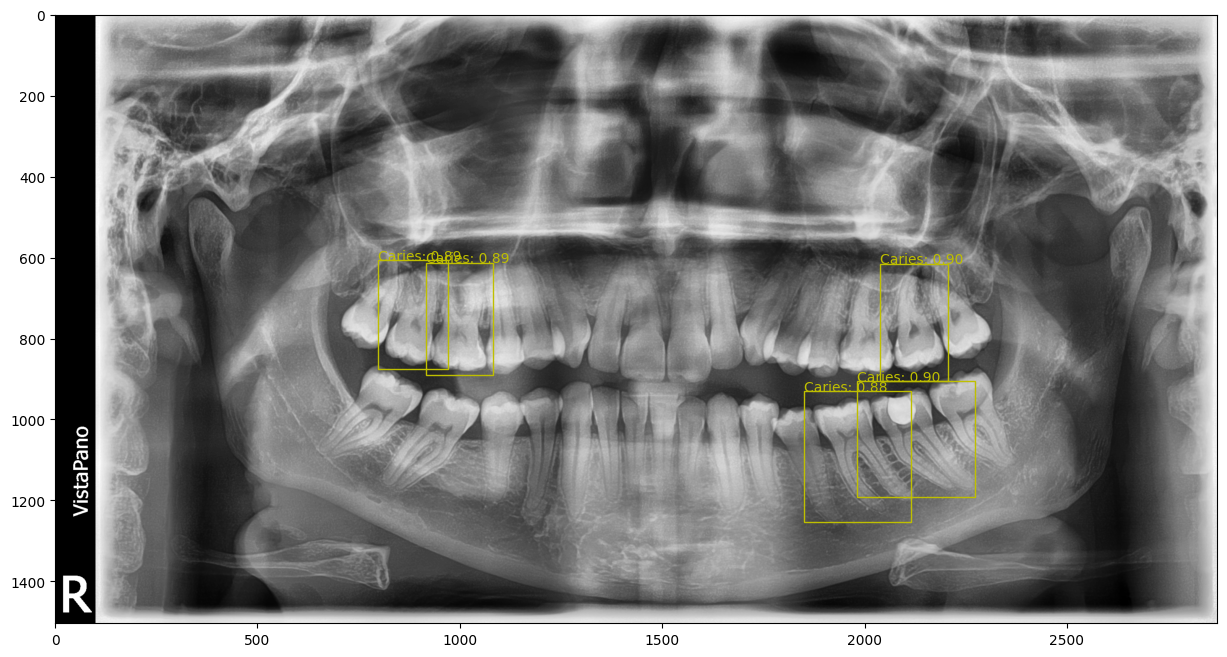

In [113]:
show_image(original_image, original_boxes, labels, scores)

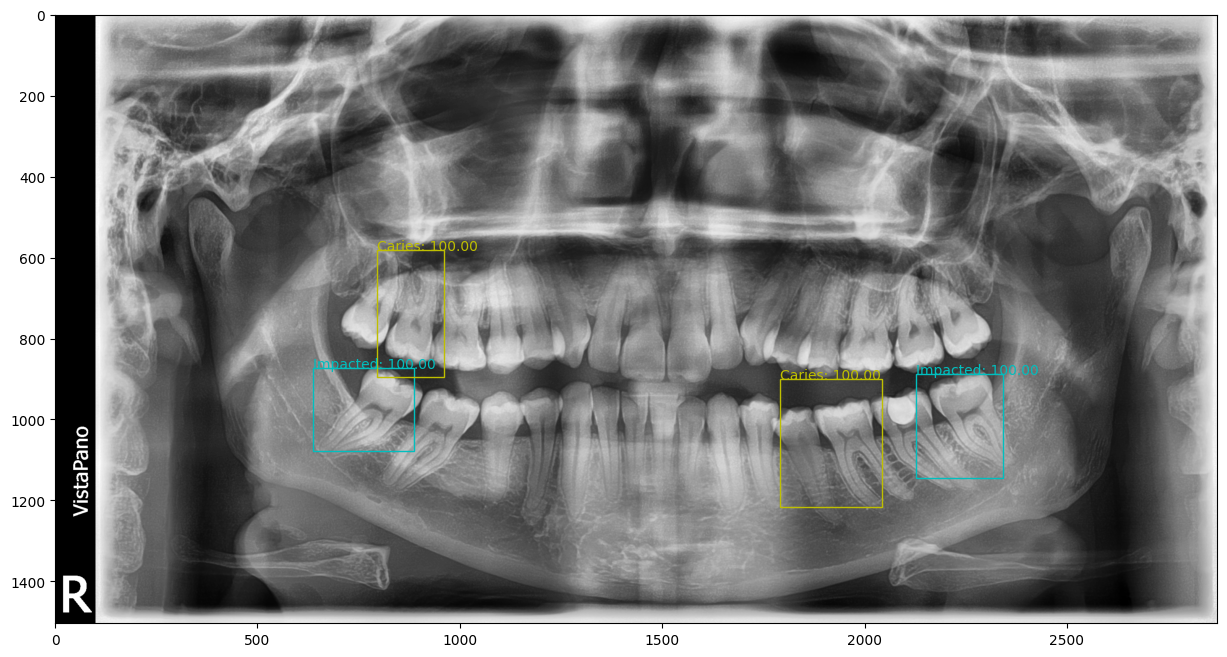

In [114]:
show_image(original_image, true_bboxes, true_labels, true_scores)